# Gradient methods

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### 1. Implementations of  step choosing methods

In [114]:
# Only 1-D case
# Using ternary search
def fastest_descent_step(gradient, x, **kwargs):
    f = kwargs["f"]
    epsilon = kwargs["epsilon"]
    h_s = np.array([0, 1, 2, 4])
    f_h_s = np.array([f(x - h_s[i] * gradient) for i in range(len(h_s))])
    
    while f_h_s[0] > f_h_s[1] > f_h_s[2] > f_h_s[3]:
        h_s = 2 * h_s
        f_h_s = np.array([f(x - h_s[i] * gradient) for i in range(len(h_s))])
    
    left = h_s[0]
    right = h_s[-1]
    while right - left > 0.001:
        m1 = left + (right - left) / 3
        m2 = right - (right - left) / 3
        if f(x - m1 * gradient) < f(x - m2 * gradient):
            right = m2
        else:
            left = m1
    return left

In [115]:
def armijo_step(gradient, x, **kwargs):
    f = kwargs["f"]
    alpha = 1
    x_next = x - alpha * gradient
    while f(x_next) > f(x) + 0.3 * alpha * gradient.dot(x_next - x):
        alpha *= 0.6
        x_next = x - alpha * gradient
    return alpha

In [116]:
def const_step(gradient, x, **kwargs):
    return kwargs["step"]

In [117]:
def iteration_step(gradient, x, **kwargs):
    return 1 / (np.sqrt(kwargs["iteration"] + 1))

#### 2. Implementation of gradient descent algorithm

In [118]:
from timeit import default_timer as timer

def GradientDescent(f, gradf, x0, epsilon, num_iter, alpha_search, step=1/4):
    x = x0.copy()
    iteration = 0
    grad_norms = []
    timestamps = []
    alpha = 1
    opt_arg = {"f": f, "grad_f": gradf, "epsilon": epsilon, 
               "iteration": iteration, "step": step}
    start = timer()
    while opt_arg["iteration"] < num_iter:
        gradient = gradf(x)
        alpha = alpha_search(gradient, x, **opt_arg)
        x = x - alpha * gradient
        opt_arg["iteration"] += 1
        grad_norms.append(np.linalg.norm(gradf(x)))
        curr = timer()
        timestamps.append((curr - start) * 1000)
        if np.linalg.norm(gradf(x)) < epsilon:
            break
    end = timer()
    time = (end - start) * 1000
    result = {"x": x, "grad_norms": grad_norms, 
              "num_iter": len(grad_norms), "time": time, 
              "time_per_iter": time / len(grad_norms), 
              "timestamps": timestamps}
    return result

#### 3. Stochastic optimization problem

Problem description is located at Overleaf.

Here we need Euler-Mascheroni constant $\gamma = 0.57721566\dots$ and location parameters of our distributions.

In [119]:
from mpmath import euler
emc = float(euler)
gum_loc = 2
norm_loc = 4

We define the objective function and its gradient.

In [120]:
def f(x):
    c2 = (1 + np.pi ** 2 / 6 + emc ** 2)
    c1 = 2 * emc * (norm_loc - gum_loc)
    c0 = (norm_loc - gum_loc) ** 2
    return x[0] ** 2 * c2 - x[0] * c1 + c0

In [121]:
def gradf(x):
    c1 = 2 * (1 + np.pi ** 2 / 6 + emc ** 2)
    c0 = 2 * emc * (norm_loc - gum_loc)
    return np.array([x[0] * c1 - c0])

Solution of this optimization problem is the scale parameter for distributions. Let's have a look at their probability distribution functions.

In [122]:
result = GradientDescent(f, gradf, np.array([19]), 0.000001, 1000, const_step, step=0.1)
scale_opt = result['x']
print(scale_opt)

[0.38763876]


sample mean =  3.555530155818555
expectation =  3.5524977907438453


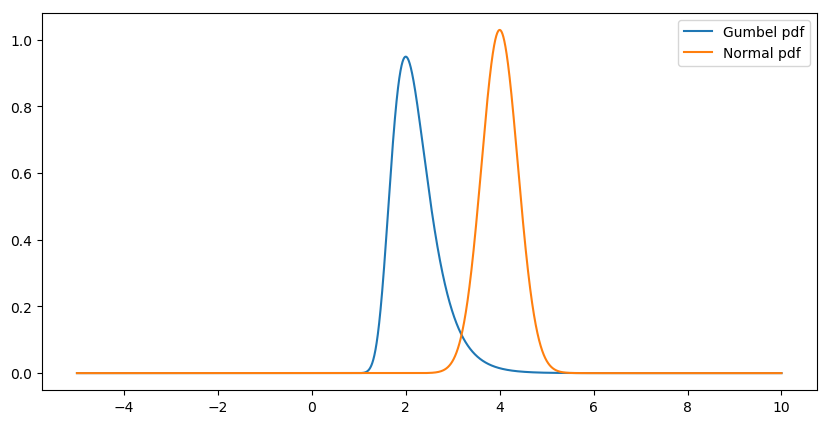

sample mean =  4.670906046333673
expectation =  4.669249331049814


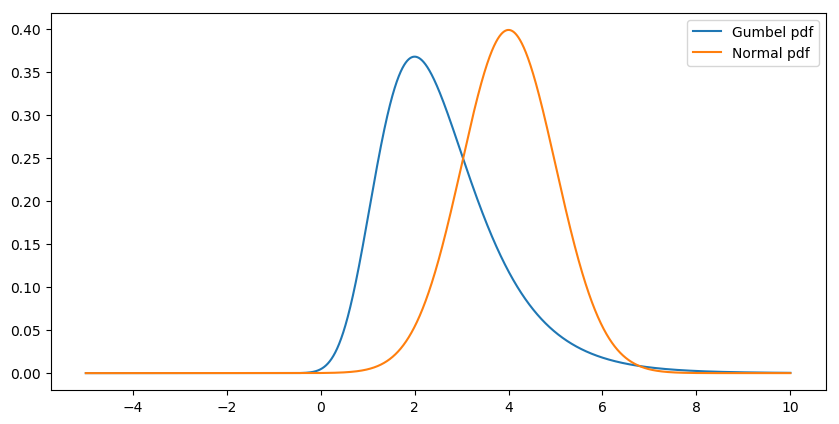

In [123]:
import scipy.stats as sts
scales = [scale_opt[0], 1.0]
for scale in scales:
    distr1 = sts.gumbel_r(loc=gum_loc, scale=scale)
    distr2 = sts.norm(loc=norm_loc, scale=scale)
    xs = np.linspace(-5, 10, 10000)
    sample1 = distr1.rvs(10000)
    sample2 = distr2.rvs(10000)
    plt.figure(figsize=(10, 5), dpi=100)
    plt.plot(xs, distr1.pdf(xs), label = 'Gumbel pdf')
    plt.plot(xs, distr2.pdf(xs), label = 'Normal pdf')
    print("sample mean = ", np.mean((sample1 - sample2) ** 2))
    print("expectation = ", f([scale]))
    plt.legend()
    plt.show()

We see that sample mean of $(\xi - \eta)^2$ is close to the theoretical expectation. When the scale which we get from optimization problem solution is used, this sample mean is less than in any other case (we take $\theta = 1$ as an example).

#### 4. Comparison of step selection methods

In [124]:
def show_res(f, gradf, x0, epsilon, num_iter, step, axs, value=None):
    result = GradientDescent(f, gradf, x0, epsilon, num_iter, step, value)
    label = step.__name__
    if value:
        label += ', ' + str(value)
        print(value)
    axs[0].semilogy(np.arange(1, result['num_iter'] + 1), result['grad_norms'], label=label)
    axs[1].semilogy(result['timestamps'], result['grad_norms'], label=label)
    for key,value in result.items():
        if key not in ['grad_norms', 'timestamps']:
            print(key, ": ", value)
    print('\n')
    

def compare(f, gradf, x0, epsilon, num_iter, values):
    steps = [armijo_step, const_step, iteration_step, fastest_descent_step]
    fig, axs = plt.subplots(2, 1, figsize=(12, 12), dpi=200)
    for step in steps:
        print(step.__name__)
        if step.__name__ == 'const_step':
            for step_value in values:
                show_res(f, gradf, x0, epsilon, num_iter, step, axs, step_value)
        else:   
            show_res(f, gradf, x0, epsilon, num_iter, step, axs)
    axs[0].set_xlabel("Number of iterations")
    axs[0].set_ylabel(r"$||\nabla f(x_k)||$")
    axs[1].set_xlabel("Time (ms)")
    axs[1].set_ylabel(r"$||\nabla f(x_k)||$")
    axs[0].legend()
    axs[1].legend()

    fig.suptitle("Comparison of step selection methods", fontsize=15)
    plt.show()

armijo_step
x :  [0.38763867]
num_iter :  18
time :  3.8017949991626665
time_per_iter :  0.2112108332868148


const_step
0.3
x :  [0.38763867]
num_iter :  94
time :  3.45158400159562
time_per_iter :  0.03671897874037894


0.1
x :  [0.38763867]
num_iter :  25
time :  0.5783619999419898
time_per_iter :  0.02313447999767959


0.25
x :  [0.38763867]
num_iter :  32
time :  0.7284249950316735
time_per_iter :  0.022763281094739796


0.15
x :  [0.38763866]
num_iter :  11
time :  0.35207500332035124
time_per_iter :  0.03200681848366829


iteration_step
x :  [0.38763866]
num_iter :  32
time :  0.8614510006736964
time_per_iter :  0.026920343771053012


fastest_descent_step
x :  [0.38763865]
num_iter :  4
time :  1.1886469947057776
time_per_iter :  0.2971617486764444




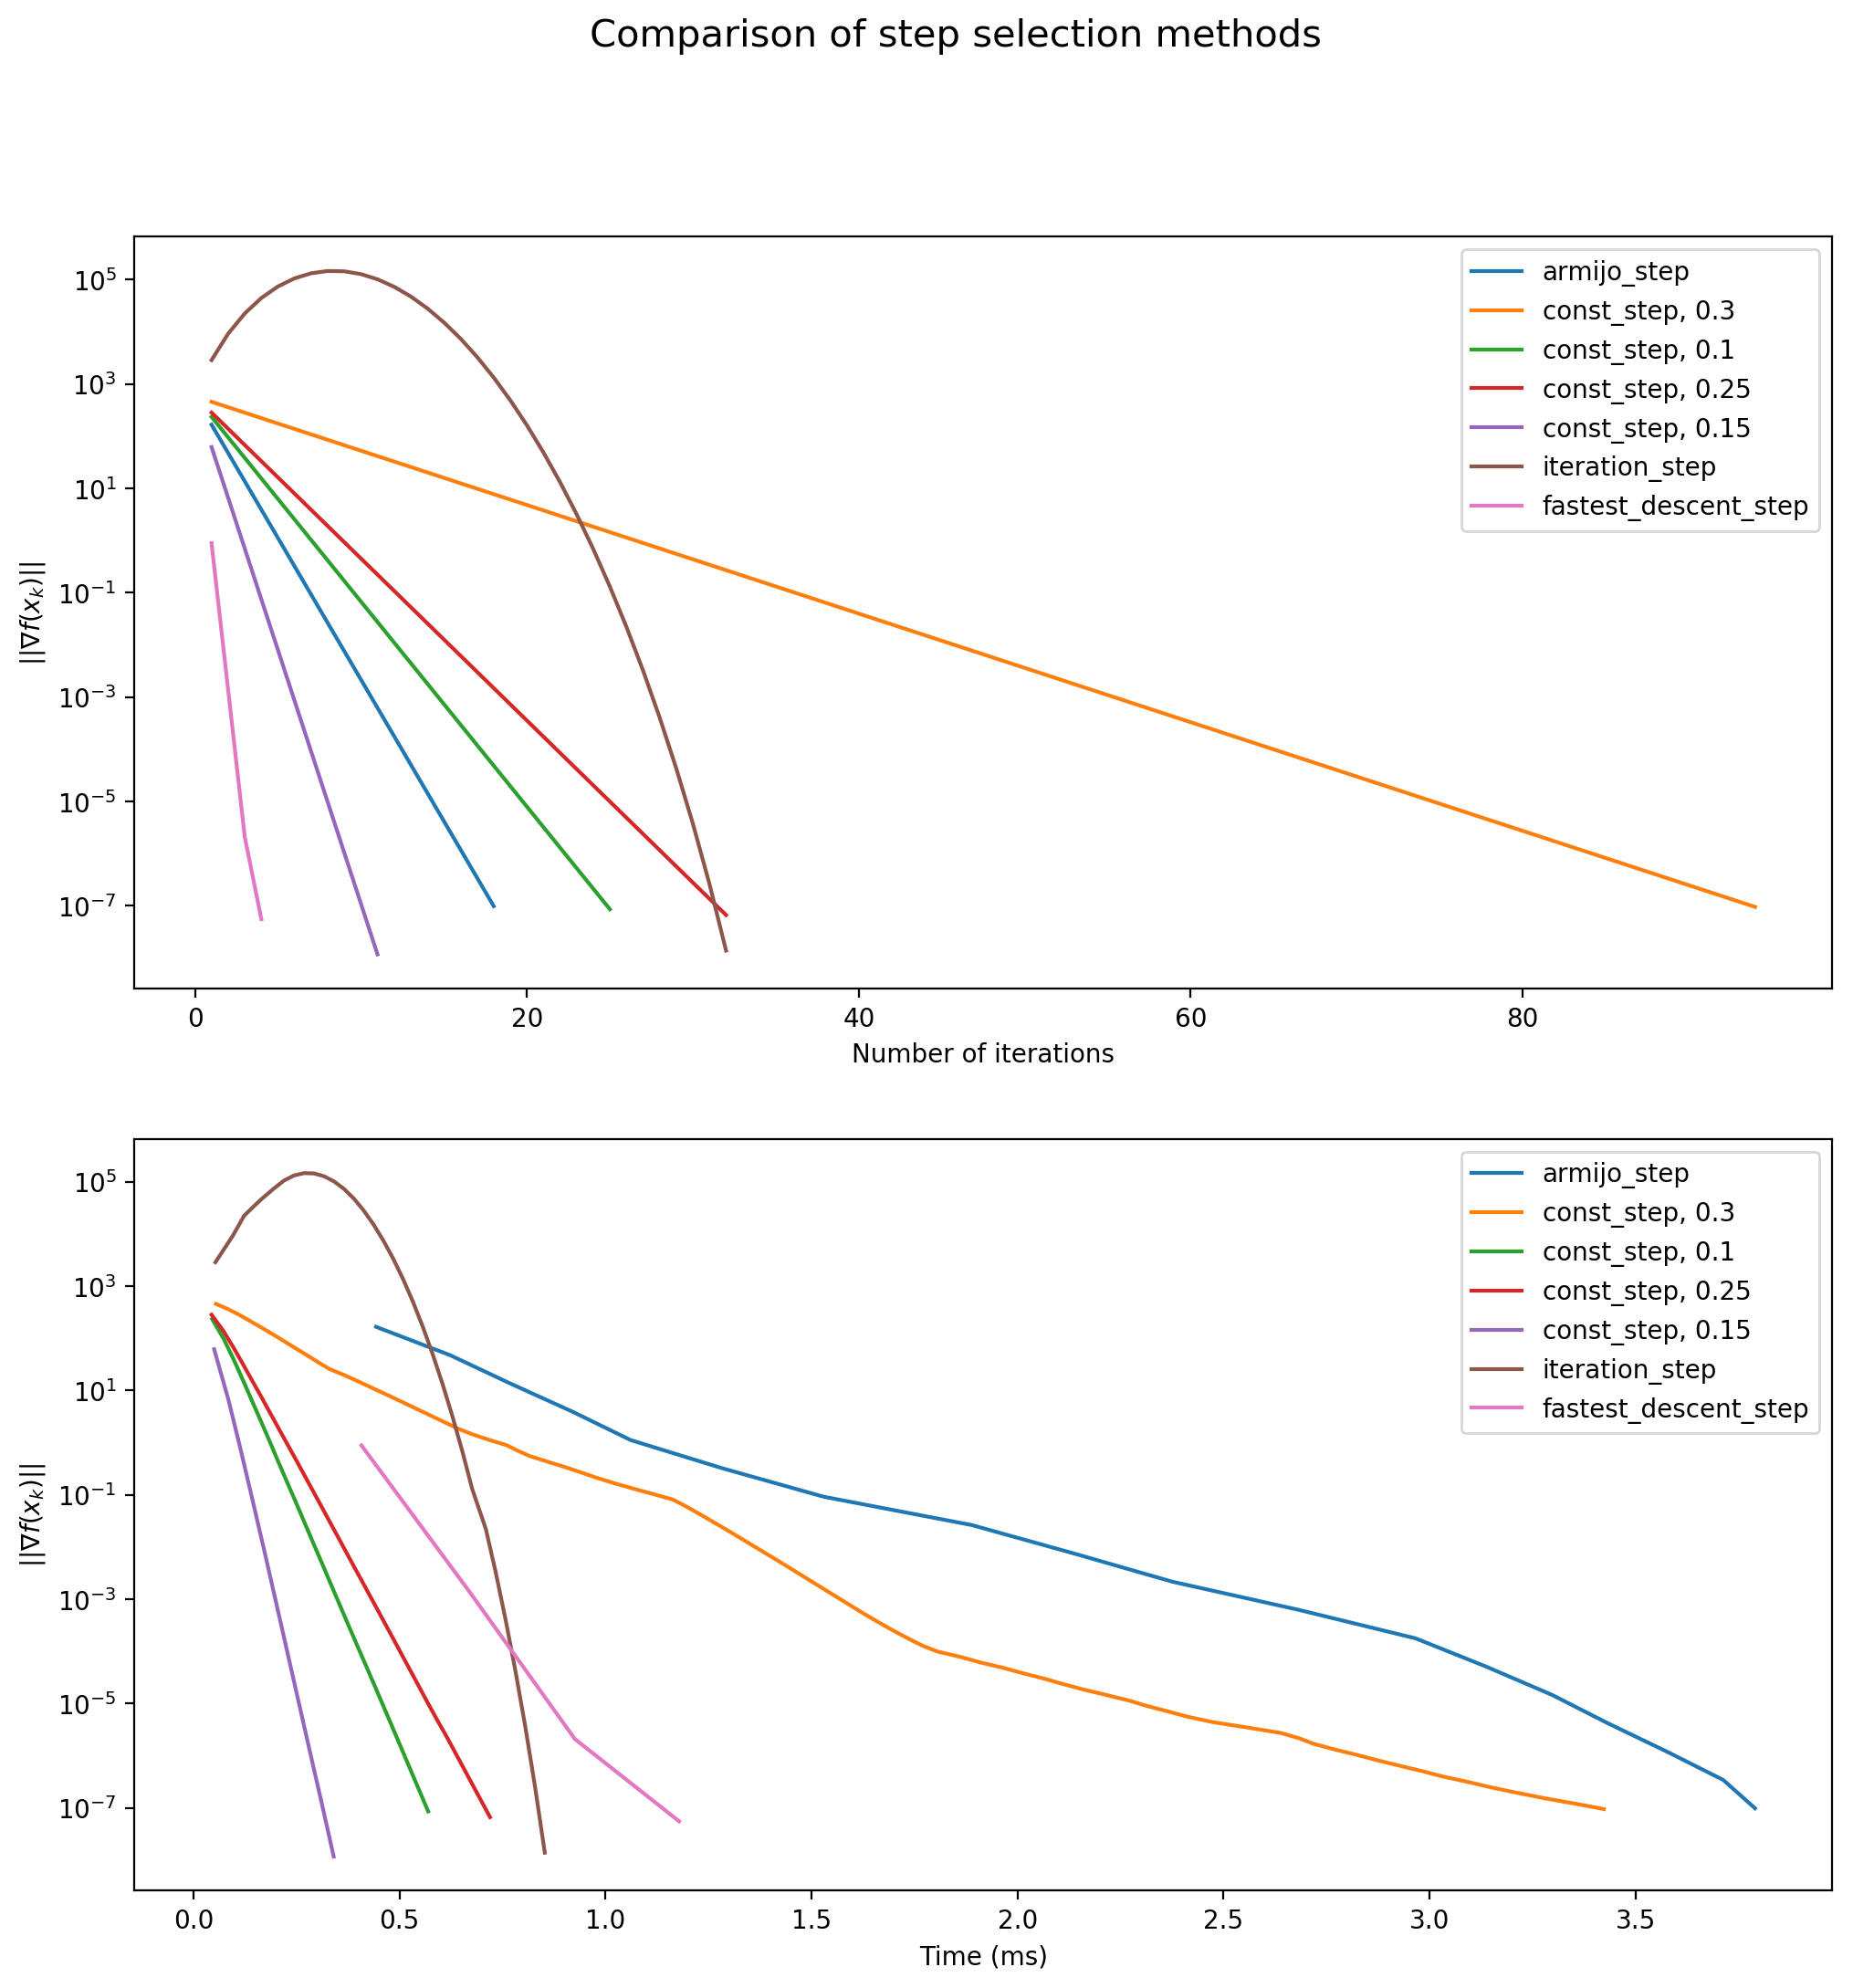

In [125]:
compare(f, gradf, np.array([98]), 10 ** (-7), 1000, values=[0.3, 0.1, 0.25, 0.15])

We see that the method of fastest descent requires the least amount of iterations, though each iteration takes the most time in comparison to other methods considered. Using constant step $0.15$ needs not much more iterations to get the answer and is approximately 5 times faster.

#### 5. Worst-case optimization problem

Again, visit Overleaf for problem description. First, let's solve the problem.

In [126]:
def f(theta, x):
    return -theta[0] ** 2 + x ** 2
def gradf(theta):
    return np.array([-2 * theta[0]])

x_s = np.linspace(-2, 2, 1001)
min_theta = None
min_x = None
min_f_theta = 100000000
for x in x_s:
    f_x = lambda t: f(t, x)
    # we need to maximize the function so we take -f and -grad
    result = GradientDescent(lambda t: -f_x(t), lambda t: -gradf(t), 
                                       np.array([100]), 0.0000001, 1000, iteration_step)
    theta = result['x']
    if f_x(theta) < min_f_theta:
        min_f_theta = f_x(theta)
        min_x = x
        min_theta = theta

In [127]:
print("min_function = ", min_f_theta)
print("x = ", min_x)
print("theta = ", min_theta[0])

min_function =  0.0
x =  0.0
theta =  0.0


We got the right solution. Let's make a comparison for random $x$.

x =  -0.7001659520806318
armijo_step
x :  [1.6384e-08]
num_iter :  14
time :  1.286376005737111
time_per_iter :  0.09188400040979364


const_step
0.15
x :  [3.55615303e-08]
num_iter :  61
time :  1.517532997240778
time_per_iter :  0.02487759011870128


0.2
x :  [4.81229803e-08]
num_iter :  42
time :  1.1185719995410182
time_per_iter :  0.02663266665573853


0.25
x :  [4.65661287e-08]
num_iter :  31
time :  0.9129930040217005
time_per_iter :  0.029451387226506465


0.3
x :  [2.81474977e-08]
num_iter :  24
time :  0.6458030038629659
time_per_iter :  0.026908458494290244


iteration_step
x :  [0.]
num_iter :  4
time :  0.14194699906511232
time_per_iter :  0.03548674976627808


fastest_descent_step
x :  [1.0304072e-08]
num_iter :  3
time :  1.0101579973706976
time_per_iter :  0.33671933245689917




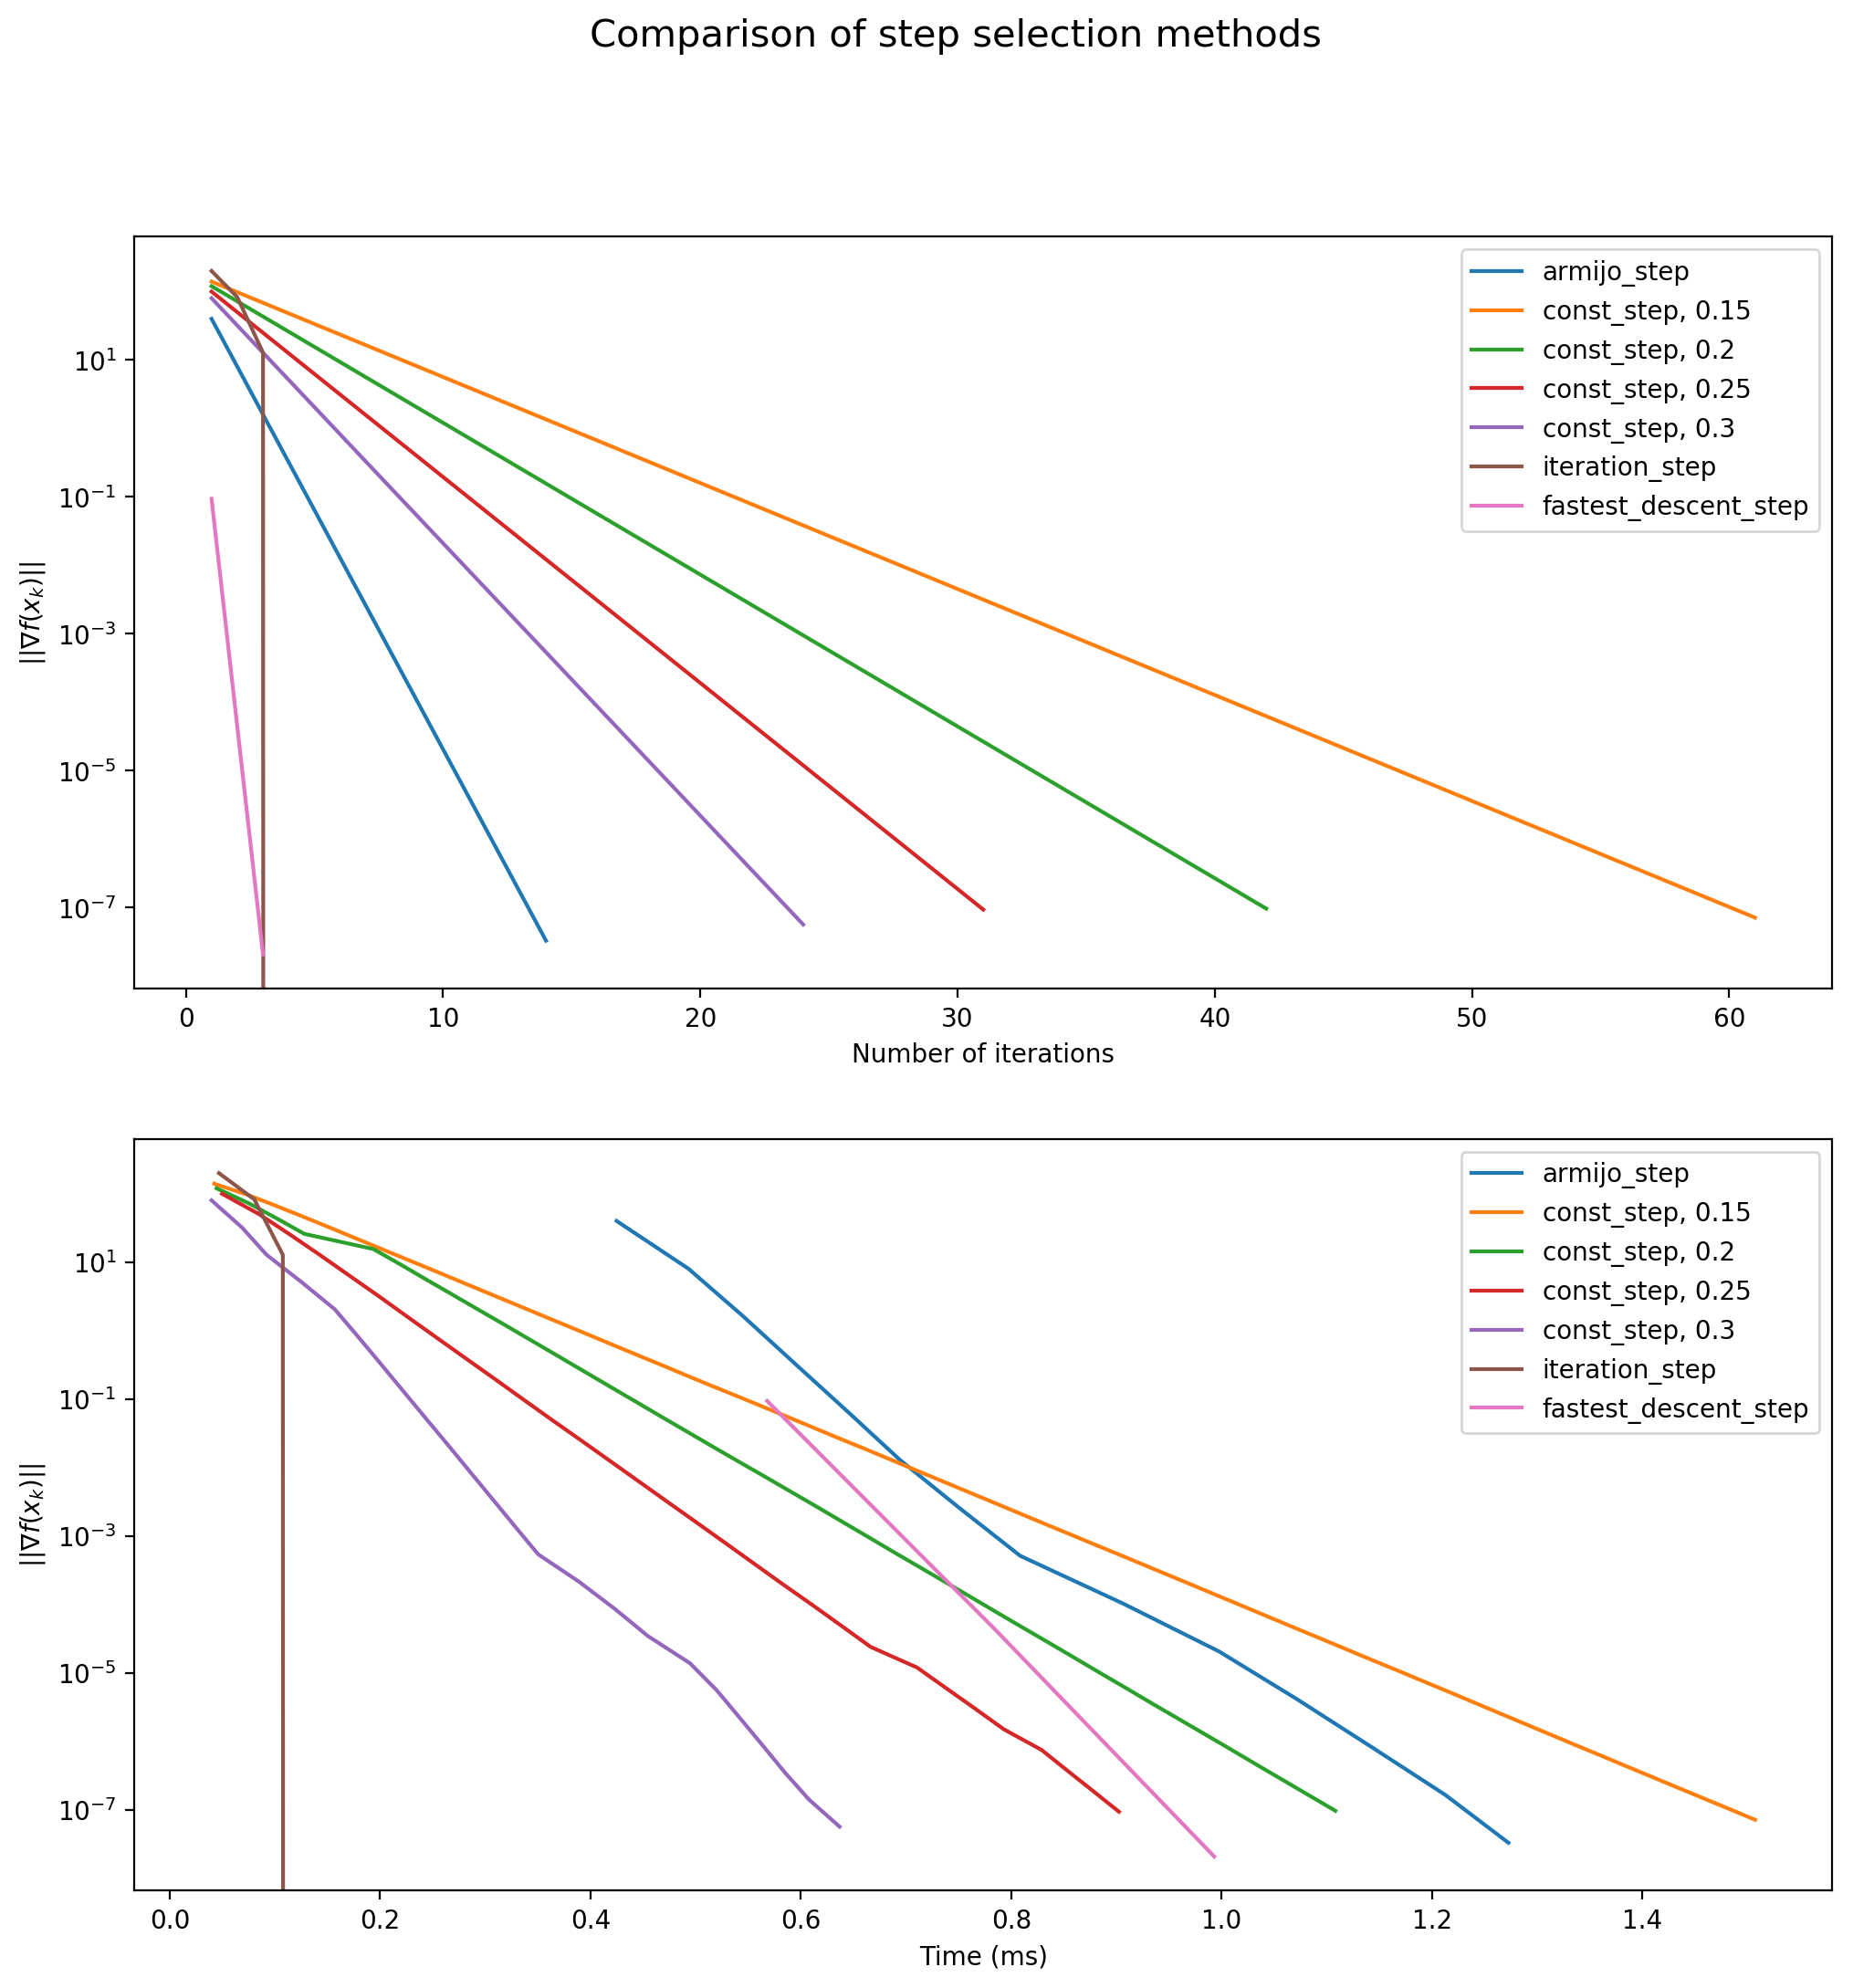

In [128]:
x = np.random.uniform(-2, 2)
print('x = ', x)
f_x = lambda t: f(t, x)
compare(lambda t: -f_x(t), lambda t: -gradf(t), 
        np.array([100]), 10 ** (-7), 1000,
        values=[0.15, 0.2, 0.25, 0.3])

Here iteration-dependent steps give best results (they require the least amount of iterations, though 'fastest descent' is still quite slow). Moreover, sequentially decreasing step provides the exact solution very fast. For constant steps,  the larger the constant is (out of 4 given ones), the better.